# satCORPS composite Sketch #2 Subsetting

- Uses starepandas branch granular_democracy


In [ ]:
import pystare
import starepandas
import geopandas

import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import dask

In [3]:
from starepandas.io.granules import Granule

class satcorps_composite(Granule):

    def __init__(self, file_path, sidecar_path=None):
        super(satcorps_composite, self).__init__(file_path, sidecar_path)
        self.nom_res = ''
        self.companion_prefix = 'composite'
        
        self.source_nc = starepandas.io.s3.nc4_dataset_wrapper(self.file_path, 'r', format='NETCDF4')
        self.lat = None
        self.lon = None
        self.data = {}

    def read_data(self):
        if False:
            dataset_names = ['time' # "days since 1858-11-17T00:00:00.000"
                             ,'map_data/BT_10.8um']

            for dataset_name in dataset_names:
                self.data[dataset_name] = self.source_nc.select(dataset_name).get()
        
#        self.data['time'] = self.source_nc['time'][:].astype(numpy.double)
        self.data['map_data/BT_12.0m'] = self.source_nc.groups['map_data']['BT_12.0um'][:].astype(numpy.double)
            
starepandas.io.granules.granule_factory_library['composite']=satcorps_composite

starepandas.io.granules.granule_factory_library

{'MOD05|MYD05': starepandas.io.granules.modis.Mod05,
 'MOD09|MYD09': starepandas.io.granules.modis.Mod09,
 'VNP02DNB|VJ102DNB': starepandas.io.granules.viirsl2.VNP02DNB,
 'VNP03DNB|VJ103DNB': starepandas.io.granules.viirsl2.VNP03DNB,
 'VNP03MOD|VJ103MOD': starepandas.io.granules.viirsl2.VNP03MOD,
 'CLDMSKL2VIIRS': starepandas.io.granules.viirsl2.CLDMSKL2VIIRS,
 'SSMIS': starepandas.io.granules.ssmis.SSMIS,
 'ATMS': starepandas.io.granules.atms.ATMS,
 'composite': __main__.satcorps_composite}

In [57]:
# Load the granule
if True:
    granule_name = 'ignored/satCORPS/composite_20220420_2019.182.0230.nc'
    composite = starepandas.read_granule(granule_name, sidecar=True, latlon=False, sidecar_path='ignored/satCORPS/satCORPS_composite_stare.nc')

In [70]:
composite

,sids,map_data/BT_12.0m
0,4017204261523273368,NaN
1,4017204261523247416,NaN
2,4017204261523249592,NaN
3,4017204261522814744,NaN
4,4017204261522830296,NaN
...,...,...
88711195,2287821927561911288,NaN
88711196,2287821927561922552,NaN
88711197,2287821927561869976,NaN
88711198,2287821927561869144,NaN


In [69]:
composite.dropna(subset=['map_data/BT_12.0m'])

,sids,map_data/BT_12.0m
9835783,3740459244108507245,253.629990
9835828,3740276042303935693,259.929993
9835874,3715571939467885805,254.029999
9835926,3715586799536894989,253.629990
9835927,3715586916865045581,253.729996
...,...,...
78880312,1968157704643308941,233.860001
78880354,1968144067628206925,247.229996
78880392,1972795376823906349,245.889999
78880429,1972822129441793229,244.199997


In [58]:
numpy.amin(composite['map_data/BT_12.0m']),numpy.amax(composite['map_data/BT_12.0m'])

(183.61000061035156, 328.8999938964844)

In [25]:
# Get some locales
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.sort_values(by='name', inplace=True)
world = starepandas.STAREDataFrame(world)

/Users/mrilee/opt/anaconda3/envs/pystare-dev/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mrilee/opt/anaconda3/envs/pystare-dev/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

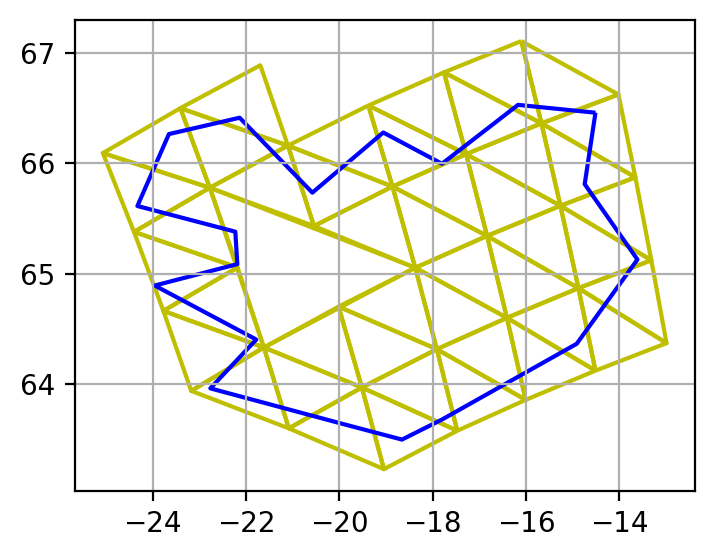

In [63]:
#
fig, ax = plt.subplots(figsize=(4,4), dpi=200)
ax.grid(True)

# country = world[world.name=='United States of America']
# country = world[world.name=='Hawaii']
country = world[world.name=='Iceland']
country.set_sids(country.make_sids(resolution=7),inplace=True)
country.set_trixels(country.make_trixels(),inplace=True)
country.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=1)
country.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)
# modis.plot(ax=ax, color='red', trixels=False, zorder=0)

del fig,ax

In [64]:
a = composite.stare_intersects(country['sids'].iloc[0],n_workers=50)

In [66]:
a

0           False
1           False
2           False
3           False
4           False
            ...  
88711195    False
88711196    False
88711197    False
88711198    False
88711199    False
Length: 88711200, dtype: bool

In [65]:
joined = starepandas.stare_join(composite, country, how='left')

In [67]:
joined

,sids_left,map_data/BT_12.0m,key_right,pop_est,continent,name,iso_a3,gdp_md_est,geometry,sids_right,trixels
0,4017204261523273368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
1,4017204261523247416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
2,4017204261523249592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
3,4017204261522814744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
4,4017204261522830296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...
88711195,2287821927561911288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
88711196,2287821927561922552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
88711197,2287821927561869976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
88711198,2287821927561869144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None


In [71]:
country

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,sids,trixels
144,339747,Europe,Iceland,ISL,16150.0,"POLYGON ((-14.50870 66.45589, -14.73964 65.808...","[3732780403648364550, 3661989447005634567, 366...","MULTIPOLYGON (((-22.77442 65.77646, -21.61535 ..."


In [53]:
del fig,ax

In [55]:
fig, ax = plt.subplots(figsize=(4,4), dpi=200)
ax.grid(True)

joined.plot(ax=ax)

if False:
    country = world[world.name=='United States of America']
    country.set_sids(country.make_sids(resolution=7),inplace=True)
    country.set_trixels(country.make_trixels(),inplace=True)
    country.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=1)
    country.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)
    # modis.plot(ax=ax, color='red', trixels=False, zorder=0)
    
del fig,ax

Error in callback <function flush_figures at 0x12a85fe50> (for post_execute):


KeyboardInterrupt: 

In [56]:
joined

,sids_left,map_data/BT_12.0m,key_right,pop_est,continent,name,iso_a3,gdp_md_est,geometry,sids_right,trixels
0,4017204261523273368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
1,4017204261523247416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
2,4017204261523249592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
3,4017204261522814744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
4,4017204261522830296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...
88711195,2287821927561911288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
88711196,2287821927561922552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
88711197,2287821927561869976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
88711198,2287821927561869144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None


In [ ]:
source_nc = starepandas.io.s3.nc4_dataset_wrapper(granule_name, 'r', format='NETCDF4')

In [6]:
data={}

In [7]:
data['map_data/BT_12.0m'] = source_nc.groups['map_data']['BT_12.0um'][:].astype(numpy.double)

In [9]:
data['time'] = source_nc['time']

In [12]:
data['time'][:].flatten()

masked_array(data=[58665.10416667],
             mask=False,
       fill_value=1e+20)

In [17]:
source_nc.groups['map_data']['BT_12.0um'][1000][1000]

236.59999

In [10]:
data.keys()

dict_keys(['map_data/BT_12.0m'])

In [40]:
source_nc.groups['map_data'].variables.keys()

dict_keys(['lat', 'lon', 'solar_zenith', 'view_zenith', 'relative_azimuth', 'ref_0.63um', 'ref_0.86um', 'BT_3.75um', 'BT_6.75um', 'BT_10.8um', 'BT_12.0um', 'SW_broadband_albedo', 'LW_broadband_flux', 'cloud_phase', 'cloud_optical_depth', 'cloud_eff_particle_size', 'cloud_eff_height', 'cloud_top_height', 'cloud_eff_temperature', 'cloud_eff_pressure', 'skin_temperature', 'surface_type', 'relative_time', 'satellite_ID'])

In [12]:
!ls

00-HelloEarth.ipynb
01-GeoLocation.ipynb
02-SpatialIntervals.ipynb
03-SpatialRange.ipynb
04-Contains.ipynb
05-HullsAndGrids.ipynb
05.1-CoverFromGeolocationArray-WalkAroundPerimeter-1.ipynb
06-SanJoaquin.ipynb
07-MODIS+Africa.ipynb
08-Pystareplotlib-1.ipynb
09-FunWithSwaths-1.ipynb
2021-0212-Sketch-StarePrism-1.ipynb
999-A0-GraphicsSketch-1.ipynb
999-B0-ModisL2Granule-Checkup-1.ipynb
999-C0-HelloEarthUpdate_MB-1.ipynb
999-C1-HelloEarthUpdate-MB-1.ipynb
999-D1-Schematic-1.ipynb
999-D2-Schematic-Plotly.ipynb
999-D3-SpatioTemporalUsage-Sketch-1.ipynb
999-E0-VizLatLonList-1.ipynb
999-F0-GridCovers-1.ipynb
999-F0-GridCovers-2.ipynb
999-G0-satCORPS-STARE-Sketch-1.ipynb
999-G0-satCORPS-STARE-Sketch-2.ipynb
9u-Integration-Demo-1.ipynb
9w-Geopandas-1.ipynb
9x-IntegrationAndDask.ipynb
9y-SidecarFile-Introduction.ipynb
9y.1-SidecarFile-Introduction.ipynb
9z-DevelopPystare-1.ipynb
9z.1-GatewayDebugging-1.ipynb
How_to_read_and_plot_NetCDF_MERRA-2_data_in_Python.ipynb
Mayavi Testing.ipynb
README.md
U

In [17]:
!mv satCORPS_composite_stare.nc ignored/satCORPS/